## RNN Results

In [1]:
import torch
import torch.nn as nn
import time
import sys
import nibabel as nib
import os

sys.path.append('/home/agajan/DeepMRI')
from deepmri import Datasets, utils  # noqa: E402
from DiffusionMRI.OldConvEncoder import ConvEncoder  # noqa: E402
from DiffusionMRI.OldConvDecoder import ConvDecoder  # noqa: E402
from deepmri.RNNEncoder import RNNEncoder  # noqa: E402
from deepmri.RNNDecoder import RNNDecoder  # noqa: E402
from deepmri.Conv3DRNNCell import Conv3DGRUCell  # noqa: E402

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

In [2]:
# pytorch settings
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ", device)
torch.manual_seed(0)
torch.backends.cudnn.benchmark = True  # set False whenever input size varies

Device:  cuda:0


In [15]:
# data settings
# data settings
mu = 307.3646240234375
std = 763.4876098632812
batch_size = 1
data_path = '/media/schultz/345de007-c698-4c33-93c1-3964b99c5df6/agajan/experiment_DiffusionMRI/'
trainset = Datasets.Feature4dDataset(data_path + 'tensors_4d/', max_seq_len=100)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=10)
print("Total training examples: ", len(trainset))

Total training examples:  1


In [16]:
# load originam dmri
dmri = nib.load('/media/schultz/345de007-c698-4c33-93c1-3964b99c5df6/regina/191336/Diffusion/data.nii.gz')
dmri_data = dmri.get_fdata()

In [10]:
# model settings
conv_encoder = ConvEncoder(input_channels=1)
conv_decoder = ConvDecoder(out_channels=1)

rnn_encoder = RNNEncoder(
    Conv3DGRUCell,
    input_channels=64,
    hidden_channels=64,
    kernel_size=3,
    stride=1,
    padding=1,
    hidden_kernel_size=3
)

rnn_decoder = RNNDecoder(
    Conv3DGRUCell,
    input_channels=64,
    hidden_channels=64,
    kernel_size=3,
    stride=1,
    padding=1,
    hidden_kernel_size=3,
    output_channels=64,
    output_kernel_size=3
)

# send models to device
conv_encoder.to(device)
conv_decoder.to(device)
rnn_encoder.to(device)
rnn_decoder.to(device)

# load pretrained weights
print("Loading weights")
conv_encoder_path = '/home/agajan/DeepMRI/DiffusionMRI/models/conv_encoder_epoch_21'
conv_decoder_path = '/home/agajan/DeepMRI/DiffusionMRI/models/conv_decoder_epoch_21'
conv_encoder.load_state_dict(torch.load(conv_encoder_path))
conv_decoder.load_state_dict(torch.load(conv_decoder_path))

rnn_encoder_path = '/home/agajan/DeepMRI/DiffusionMRI/models/overfit_rnn_encoder_epoch_1400'
rnn_decoder_path = '/home/agajan/DeepMRI/DiffusionMRI/models/overfit_rnn_decoder_epoch_1400'
rnn_encoder.load_state_dict(torch.load(rnn_encoder_path))
rnn_decoder.load_state_dict(torch.load(rnn_decoder_path))

# count parameters
p1 = utils.count_model_parameters(conv_encoder)
p2 = utils.count_model_parameters(conv_decoder)
p3 = utils.count_model_parameters(rnn_encoder)
p4 = utils.count_model_parameters(rnn_decoder)
print("Total trainable parameters: {}".format(p1[0] + p2[0] + p3[0] + p4[0]))

Loading weights
Total trainable parameters: 2131075


In [12]:
# evaluate
conv_encoder.eval()
conv_decoder.eval()
rnn_encoder.eval()
rnn_decoder.eval()

criterion = nn.MSELoss()

rnn_features = []
running_loss = 0.0

with torch.no_grad():
    epoch_start = time.time()

    for data in trainloader:
        iter_time = time.time()

        # -------------------Seq2Seq Start------------------ #
        src_batch = data.to(device)
        seq_len = src_batch.shape[1]

        context_batch = rnn_encoder(src_batch)

        hidden_batch = context_batch

        # first input is <sos> in learning phrase representation
        # in this case it is tensor of zeros
        input_batch = src_batch.new_zeros(src_batch[:, 0, :, :, :, :].shape)

        loss = src_batch.new_zeros(1)
        for t in range(seq_len):
            input_batch, hidden_batch = rnn_decoder(input_batch, hidden_batch, context_batch)
            rnn_features.append(input_batch)
            loss = loss + criterion(src_batch[:, t, :, :, :, :], input_batch)

        loss = loss / seq_len
        # -------------------Seq2Seq End------------------- #

        running_loss += loss.item() * data.size(0)

    epoch_loss = running_loss / len(trainset)
    print("Loss: {}, inference time: {:.5f} seconds".format(epoch_loss, time.time() - epoch_start))

# reconstruct from rnn features
rnn_recons = []
with torch.no_grad():
    for rnn_feature in rnn_features:
        rnn_recon = conv_decoder(rnn_feature)
        rnn_recons.append((rnn_recon * std + mu).clamp(min=0).cpu())

Loss: 0.07400909811258316, inference time: 2.14475 seconds


In [14]:
rnn_recons[0].shape

torch.Size([1, 1, 145, 174, 145])

## Visualize Reconstruction from Learned Features

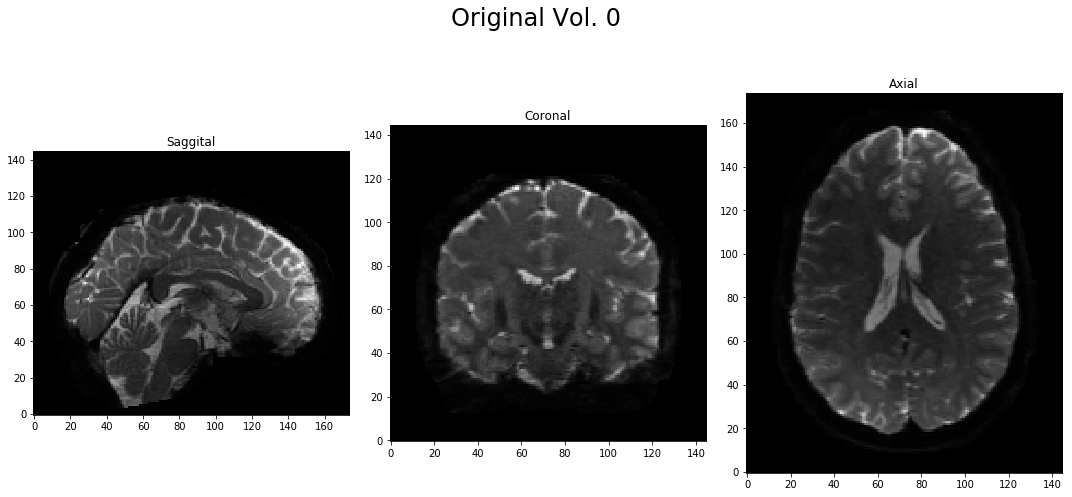

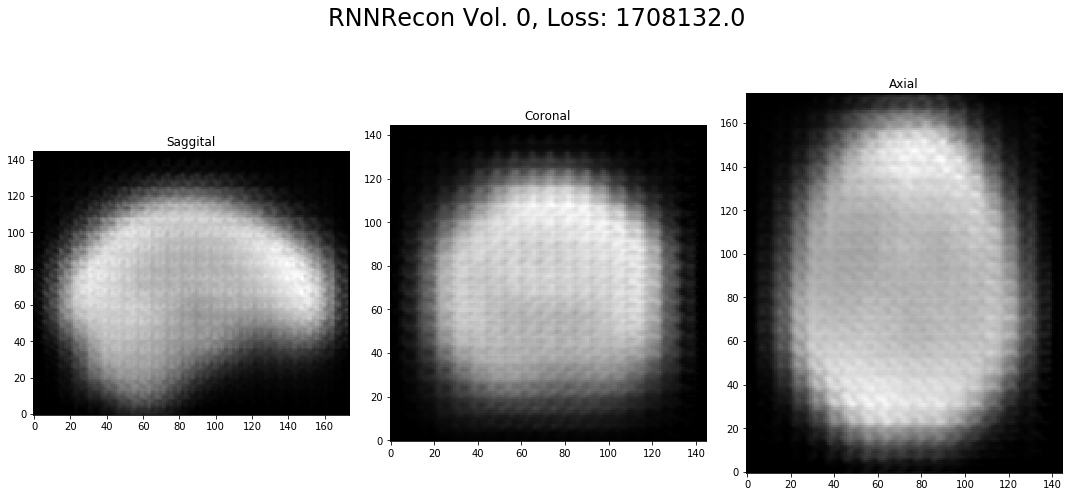

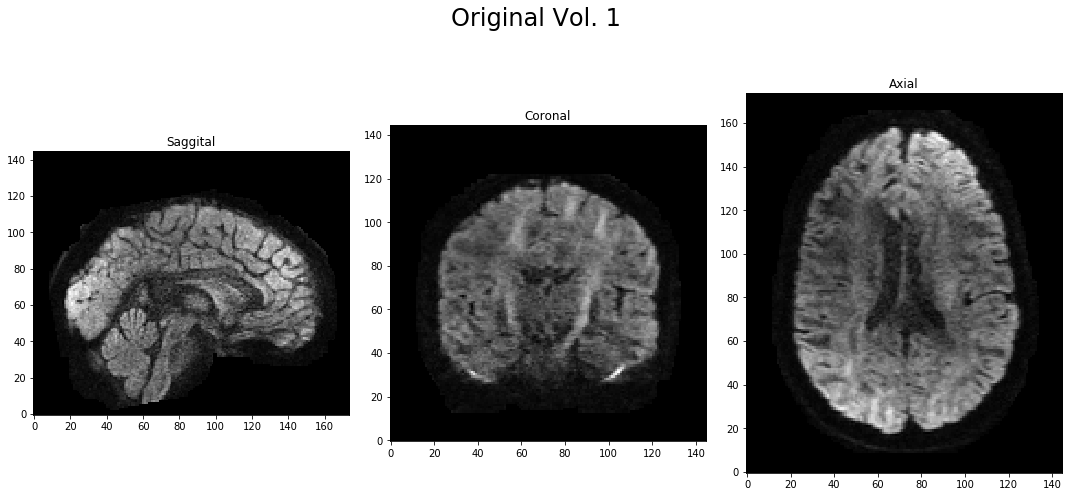

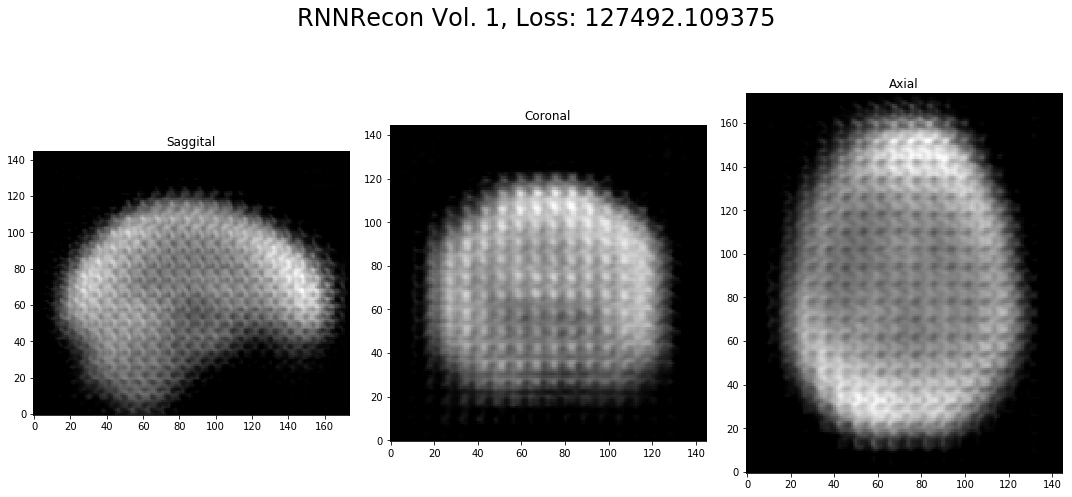

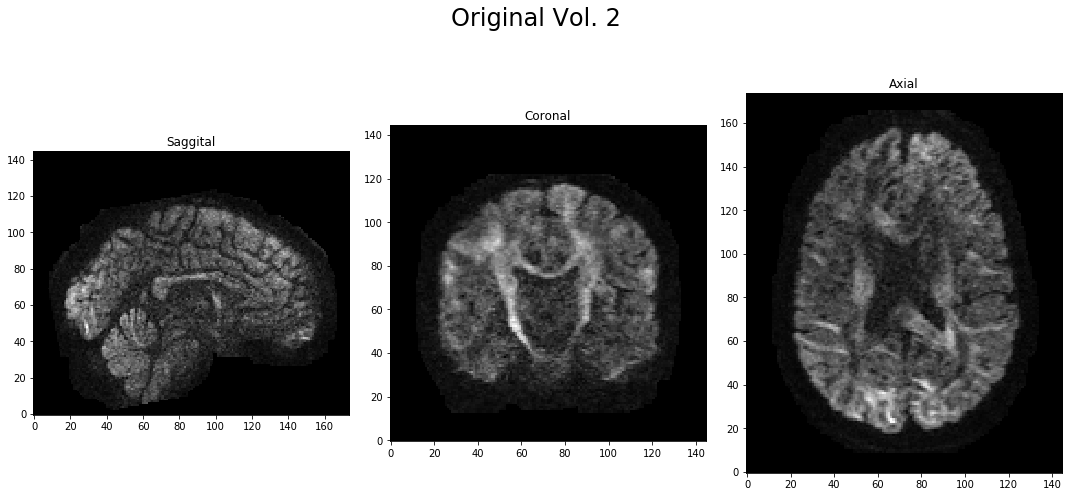

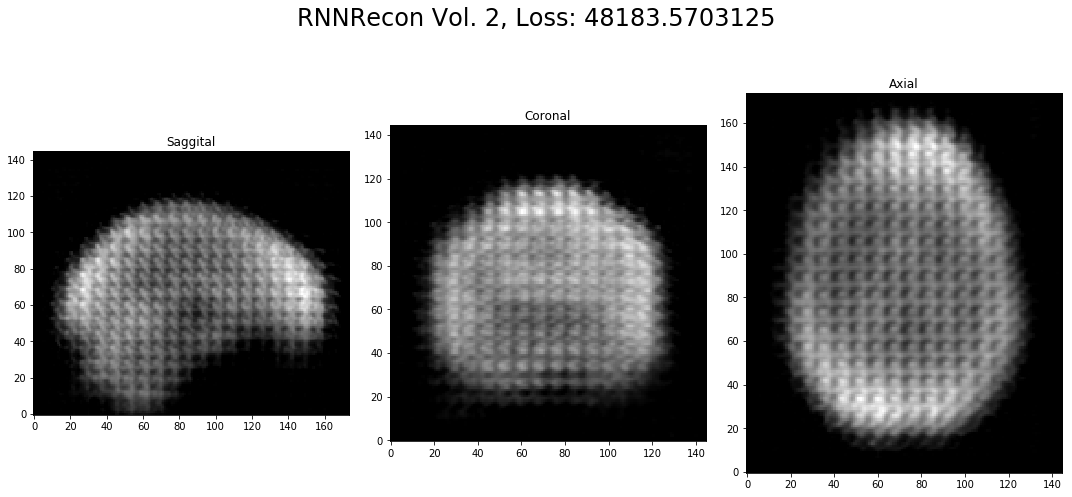

In [17]:
x_coord = 72
y_coord = 87
z_coord = 72

criterion = nn.MSELoss()

for vol_idx in range(3):
    orig = torch.tensor(dmri_data[:, :, :, vol_idx]).float()
    rnn_recon = rnn_recons[vol_idx].squeeze()
    
    rnn_vol_loss = criterion(orig, rnn_recon).item()
    
    utils.show_slices([
        orig[x_coord, :, :].numpy(),
        orig[:, y_coord, :].numpy(),
        orig[:, :, z_coord].numpy(),
    ], figsize=(15, 8), suptitle="Original Vol. {}".format(vol_idx))
    
    utils.show_slices([
        rnn_recon[x_coord, :, :].numpy(),
        rnn_recon[:, y_coord, :].numpy(),
        rnn_recon[:, :, z_coord].numpy(),
    ], figsize=(15, 8), suptitle="RNNRecon Vol. {}, Loss: {}".format(vol_idx, rnn_vol_loss))